In [1]:
import torch 
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

import os
from pathlib import Path
import glob

import numpy as np
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import random

import scipy.ndimage
import cv2

from util import *
import h5py

In [2]:
class h5_mini_batch(Dataset):
    def __init__(self,root):
        self.root = Path(root)
        self.mini_batches_names = sorted([os.path.basename(f) for f in self.root.glob('*')])
        print(self.mini_batches_names)
    def __len__(self):
        return len(self.mini_batches_names)
    def __getitem__(self, idx):
        with h5py.File(self.root/self.mini_batches_names[idx], 'r') as f:
            img1 = f["img1"][()]
            img2 = f["img2"][()]
            trg = f["target"][()]
            img1_file = torch.from_numpy(img1)
            img2_file = torch.from_numpy(img2)
            target_file = torch.from_numpy(trg)
        return img1_file,img2_file,target_file

In [3]:
flying_chairs_batch = h5_mini_batch("./Data/H5/FlyingChairs")
dataset_flyingChairs = torch.utils.data.DataLoader(flying_chairs_batch,batch_size=None,num_workers=1)

['mini_batch_0.h5', 'mini_batch_1.h5', 'mini_batch_10.h5', 'mini_batch_100.h5', 'mini_batch_1000.h5', 'mini_batch_1001.h5', 'mini_batch_1002.h5', 'mini_batch_1003.h5', 'mini_batch_1004.h5', 'mini_batch_1005.h5', 'mini_batch_1006.h5', 'mini_batch_1007.h5', 'mini_batch_1008.h5', 'mini_batch_1009.h5', 'mini_batch_101.h5', 'mini_batch_1010.h5', 'mini_batch_1011.h5', 'mini_batch_1012.h5', 'mini_batch_1013.h5', 'mini_batch_1014.h5', 'mini_batch_1015.h5', 'mini_batch_1016.h5', 'mini_batch_1017.h5', 'mini_batch_1018.h5', 'mini_batch_1019.h5', 'mini_batch_102.h5', 'mini_batch_1020.h5', 'mini_batch_1021.h5', 'mini_batch_1022.h5', 'mini_batch_1023.h5', 'mini_batch_1024.h5', 'mini_batch_1025.h5', 'mini_batch_1026.h5', 'mini_batch_1027.h5', 'mini_batch_1028.h5', 'mini_batch_1029.h5', 'mini_batch_103.h5', 'mini_batch_1030.h5', 'mini_batch_1031.h5', 'mini_batch_1032.h5', 'mini_batch_1033.h5', 'mini_batch_1034.h5', 'mini_batch_1035.h5', 'mini_batch_1036.h5', 'mini_batch_1037.h5', 'mini_batch_1038.h5',

In [4]:
class FlowDatasetTransform():
    def __init__(self, norm, size=(375, 1242), crop=(320, 896), flip=0.5):
        self.norm = norm
        self.size = size
        self.crop = crop
        self.flip = flip

        mean = np.array(self.norm.mean)
        std = np.array(self.norm.std)

        self.inv_norm = transforms.Normalize(mean=-mean/std, std=1/std)

    def __call__(self, im_1, im_2, target):
        resize = transforms.Resize(size=self.size)
        
        im_1 = resize(im_1)
        im_2 = resize(im_2)
#         print("target b4 ", target.shape)
#         print("target b4 ", target[:,:,0])
#         print("target b4 ", target[:,:,1])
        
        target = resample_flow(target, self.size)
#         print("target", target.shape)
#         print("target", target[:,:,0])
#         print("target", target[:,:,1])
        

        i, j, h, w = transforms.RandomCrop.get_params(im_1, output_size=self.crop)
#         i, j, h, w = 0, 0, self.crop[0], self.crop[1]

        im_1 = TF.crop(im_1, i, j, h, w)
        im_2 = TF.crop(im_2, i, j, h, w)
        target = target[i:i+h,j:j+w,:]

        if False: # random.random() > self.flip:
            im_1 = TF.hflip(im_1)
            im_2 = TF.hflip(im_2)
            target = cv2.flip(target, 1)

        target = target.transpose((2, 0, 1))

        im_1 = TF.to_tensor(im_1)
        im_2 = TF.to_tensor(im_2)
        target = torch.Tensor(target)

        return norm(im_1), norm(im_2), target

    def denorm(self, im):
        return self.inv_norm(im)

In [5]:
mean = (.5, .5, .5)
std = (.5, .5, .5)
norm = transforms.Normalize(mean=mean, std=std)

tfms = FlowDatasetTransform(norm,size=(384, 512),crop=(384,448))

In [6]:
def interpolate(img, x, y):
    out = []

    int_x = int(x)
    int_y = int(y)
    fractional_x = x-int_x
    fractional_y = y-int_y
    next_x = min(int_x+1,img.shape[0]-1)
    next_y = min(int_y+1,img.shape[1]-1)

    for channel in range(img.shape[2]):
        bl = img[int_x,int_y,channel]
        br = img[next_x,int_y,channel]
        tl = img[int_x,next_y,channel]
        tr = img[next_x,next_y,channel]

        bot = fractional_x * br + (1 - fractional_x) * bl
        top = fractional_x * tr + (1 - fractional_x) * tl
        pixel = fractional_y * top + (1 - fractional_y) * bot
        out.append(pixel)

    return out

def warp_flow(I2, u, v):
    """ 
    im2 warped according to (u,v)
    """
    #++++++++++++++++++++++++++++++++++++++++++++++#
    #++++++++++++++++++++++++++++++++++++++++++++++#
    # ============== YOUR CODE HERE ============== #
    
    # # this code is confusing because we assume vx and vy are the negative
    # # of where to send each pixel, as in the results by ce's siftflow code
    # y, x = np.mgrid[:im2.shape[0], :im2.shape[1]]
    # dy = (y + v).flatten()[np.newaxis, :]
    # dx = (x + u).flatten()[np.newaxis, :]
    # # this says: a recipe for making im1 is to make a new image where im[y, x] = im2[y + flow[y, x, 1], x + flow[y, x, 0]]
    # return np.concatenate([scipy.ndimage.map_coordinates(im2[..., i], np.concatenate([dy, dx])).reshape(im2.shape[:2] + (1,)) \
    #                         for i in range(im2.shape[2])], axis = 2)
    # print(u.shape)
    # print(v.shape)
    # print(I2.shape)

    u = cv2.normalize(u.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)
    v = cv2.normalize(v.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)
    I2 = cv2.normalize(I2.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)


    img = np.zeros(I2.shape)
    for i in range(I2.shape[0]):
      for j in range(I2.shape[1]):
        new_i = i + u[i,j]*50
        new_j = j + v[i,j]*50

        if new_i > -1 and new_i < I2.shape[0] and new_j > -1 and new_j < I2.shape[1]:
            # img[new_i,new_j] = I2[i,j]
            img[i,j] = interpolate(I2, new_i, new_j)
      
    
    img = cv2.normalize(img.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)
    return img
    
    # ============== END OF CODE ================= # 
    #++++++++++++++++++++++++++++++++++++++++++++++#
    #++++++++++++++++++++++++++++++++++++++++++++++#

In [7]:
def warp_flow_fast(im2, u, v):
    """ 
    im2 warped according to (u,v).
    This is a helper function that is used to warp an image to make it match another image 
    (in this case, I2 is warped to I1).
    Assumes im1[y, x] = im2[y + v[y, x], x + u[y, x]] 
    """
    # this code is confusing because we assume vx and vy are the negative
    # of where to send each pixel, as in the results by ce's siftflow code
    y, x = np.mgrid[:im2.shape[0], :im2.shape[1]]
    dy = (y + v).flatten()[np.newaxis, :]
    dx = (x + u).flatten()[np.newaxis, :]
    # this says: a recipe for making im1 is to make a new image where im[y, x] = im2[y + flow[y, x, 1], x + flow[y, x, 0]]
    return np.concatenate([scipy.ndimage.map_coordinates(im2[..., i], np.concatenate([dy, dx])).reshape(im2.shape[:2] + (1,)) \
                            for i in range(im2.shape[2])], axis = 2)

torch.Size([2, 384, 448])


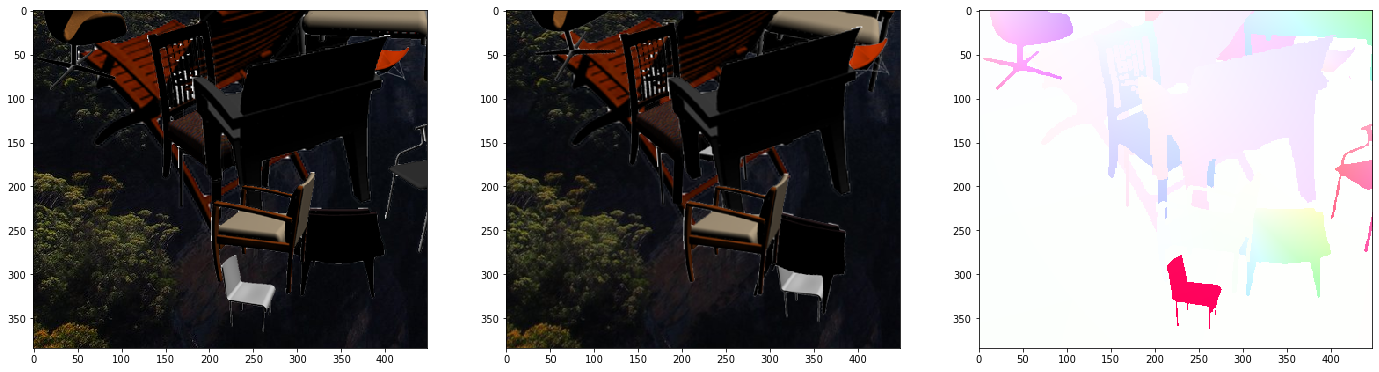

torch.Size([2, 384, 448])


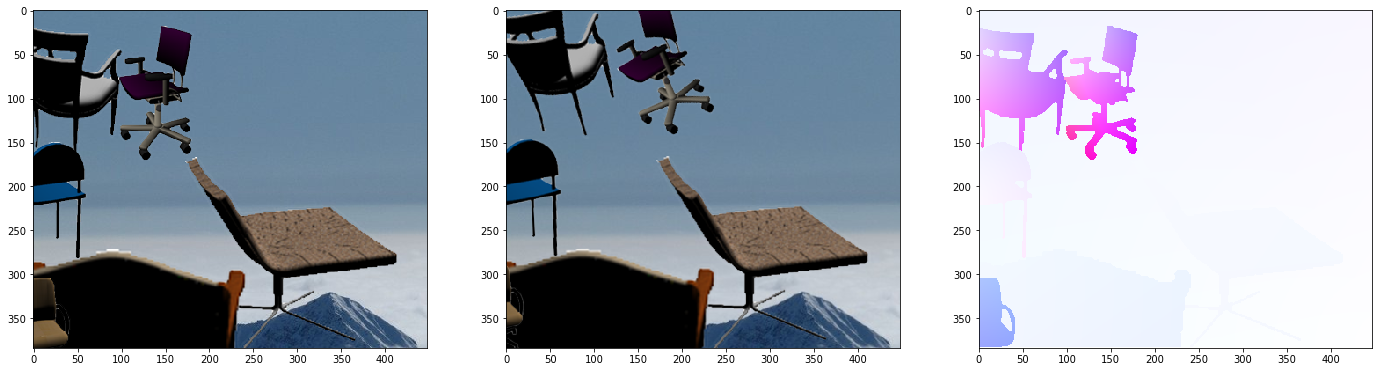

torch.Size([2, 384, 448])


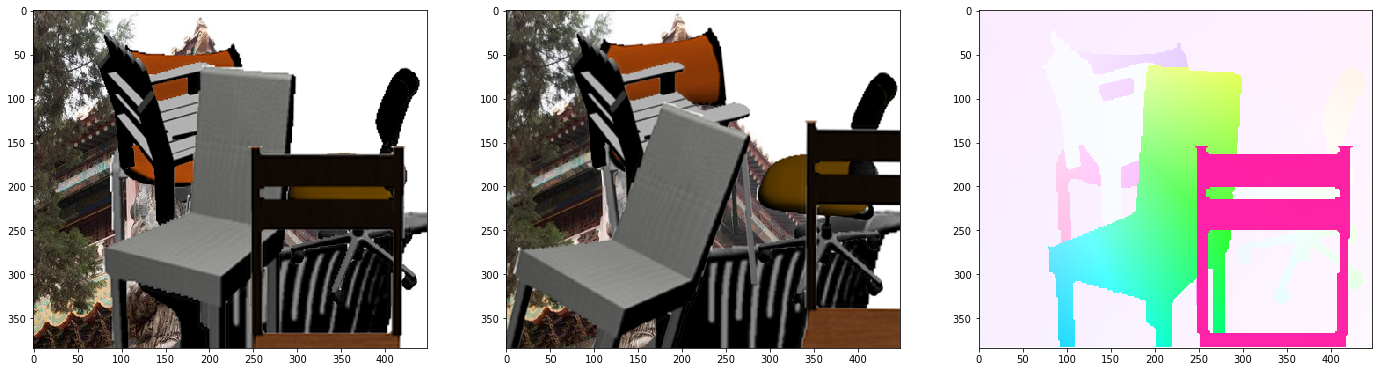

torch.Size([2, 384, 448])


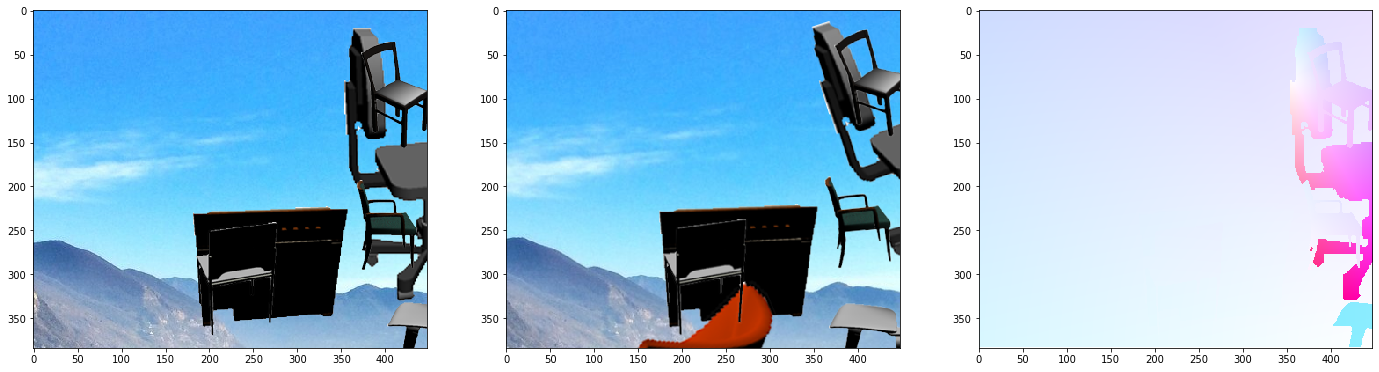

torch.Size([2, 384, 448])


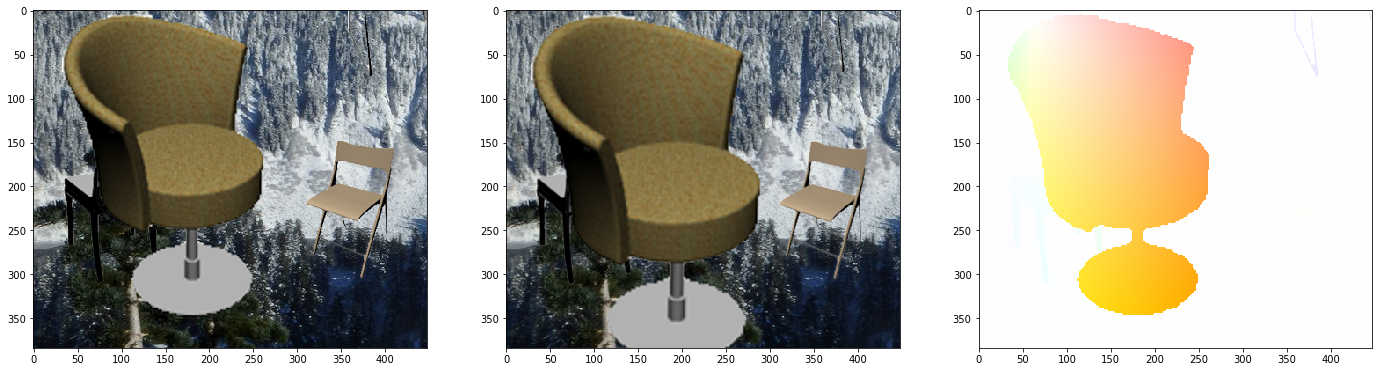

torch.Size([2, 384, 448])


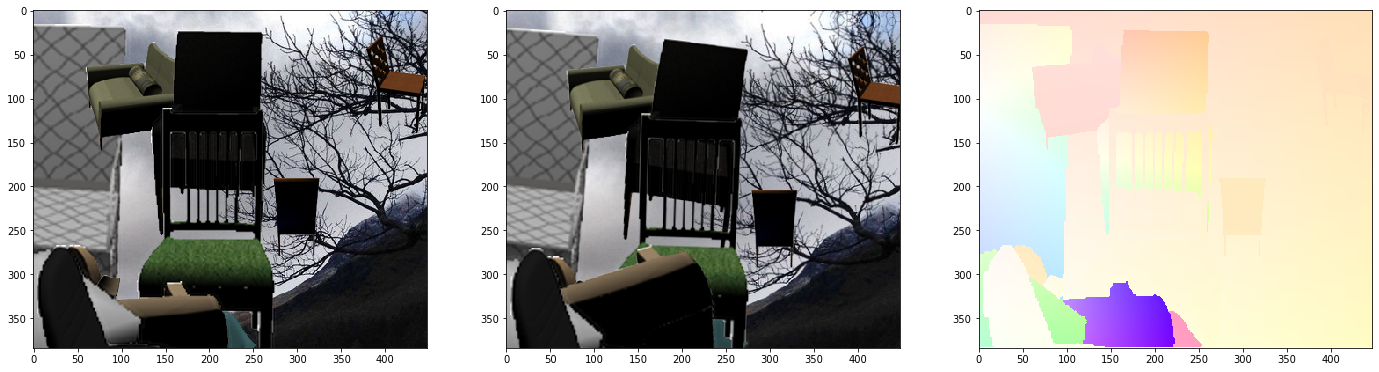

torch.Size([2, 384, 448])


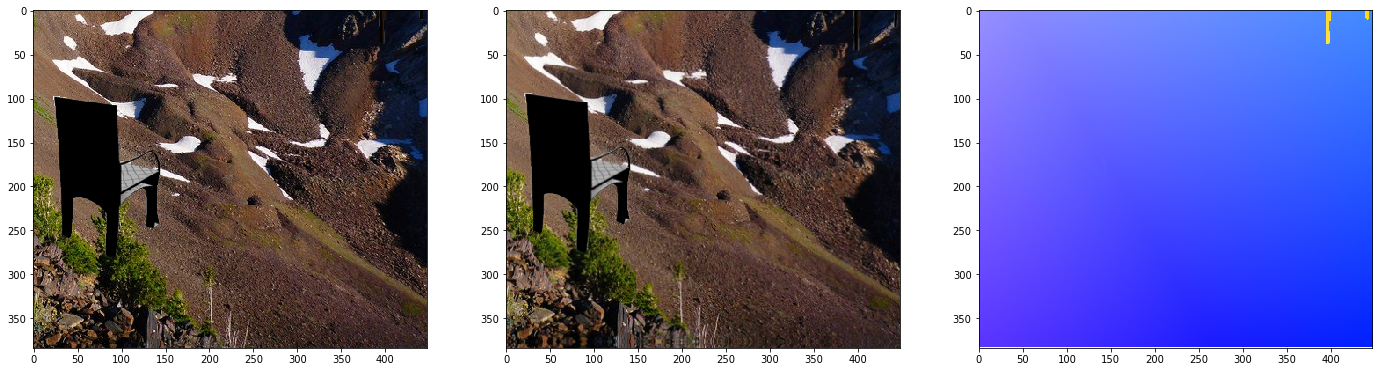

torch.Size([2, 384, 448])


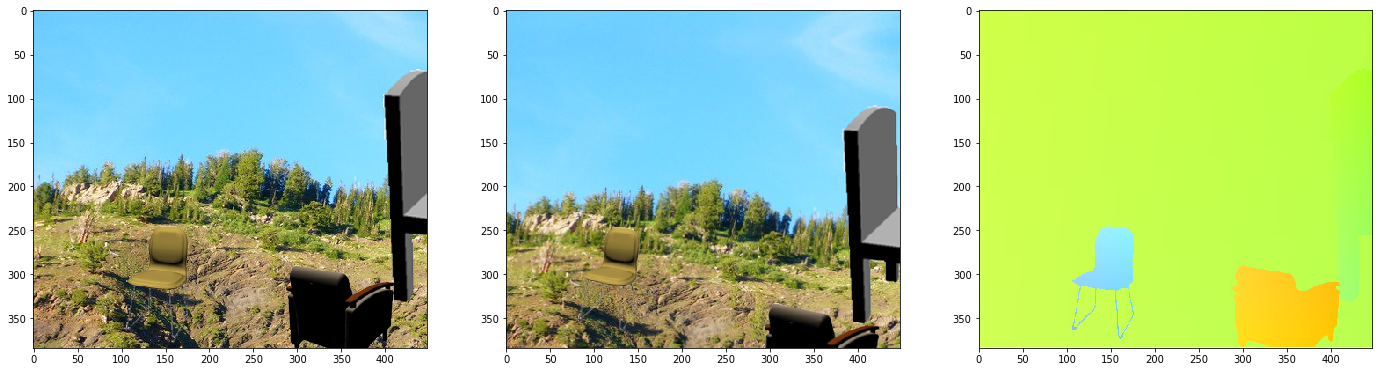

torch.Size([2, 384, 448])


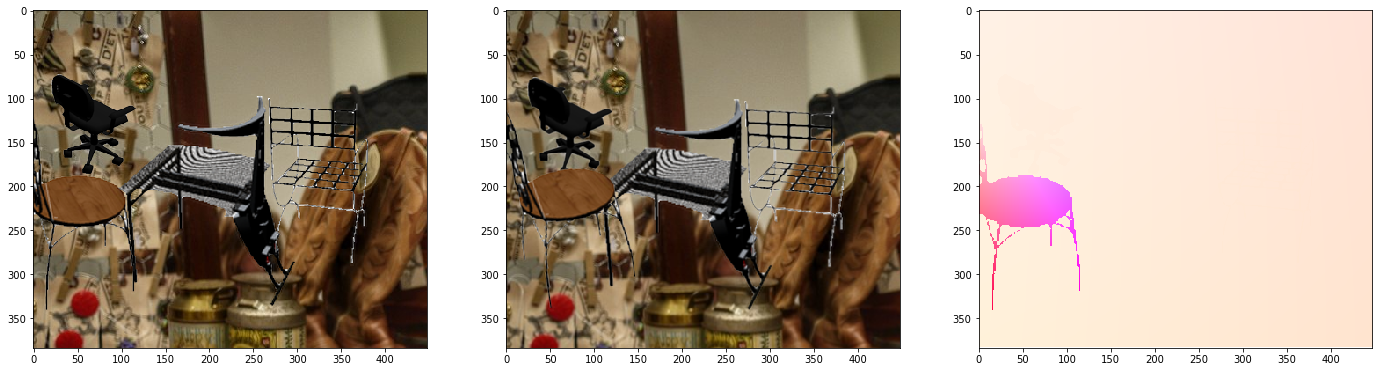

torch.Size([2, 384, 448])


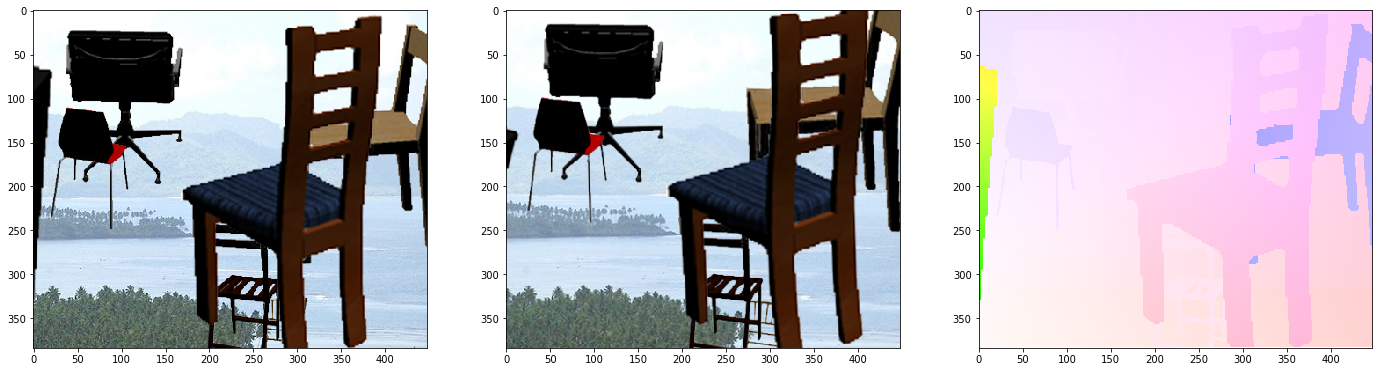

torch.Size([2, 384, 448])


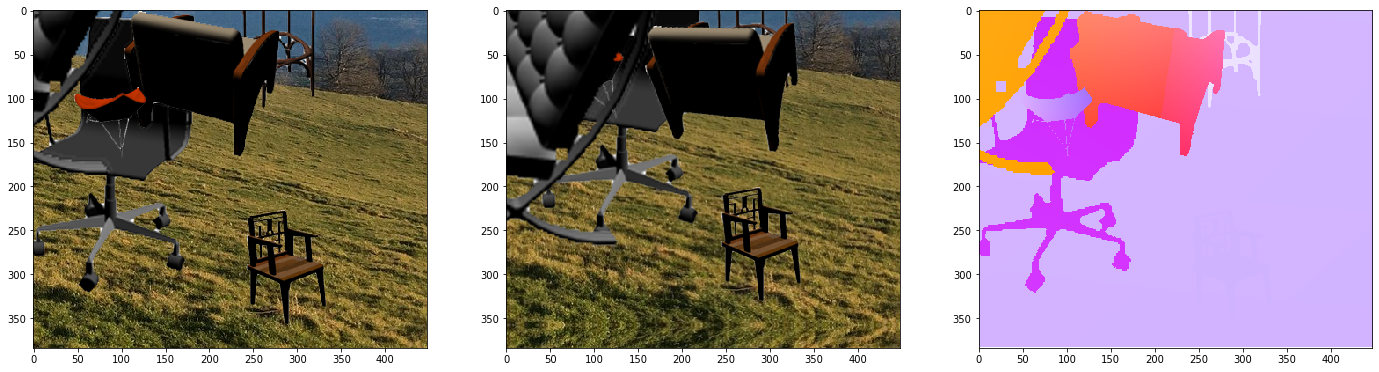

torch.Size([2, 384, 448])


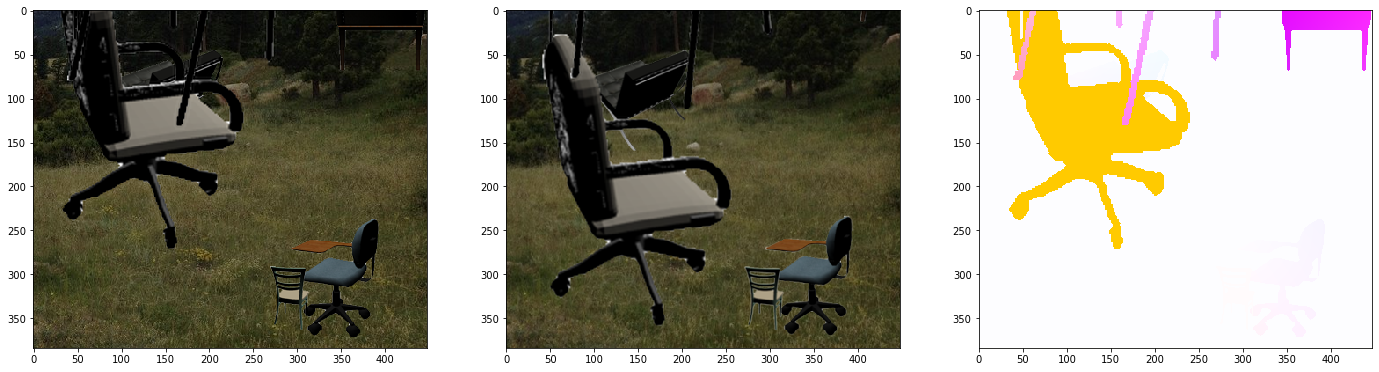

torch.Size([2, 384, 448])


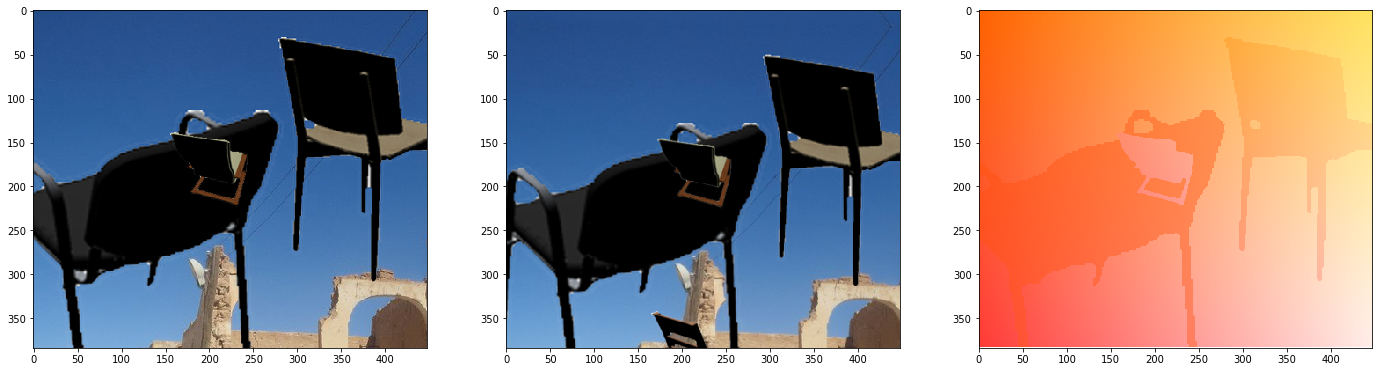

torch.Size([2, 384, 448])


KeyboardInterrupt: 

<Figure size 1728x1728 with 0 Axes>

In [8]:
for batch_im1,batch_im2,batch_target in dataset_flyingChairs:
#     print("test")
#     print(inputs1.shape)
#     print(inputs2.shape)    
#     print(target.shape)
#     for im1, im2, target in zip(batch_im1, batch_im2, batch_target):
#         print(im1.shape)
#         print(im2.shape)
    im1 = batch_im1[0]
    im2 = batch_im2[0]
    target = batch_target[0]
    print(target.shape)
    

    im1, im2 = tfms.denorm(im1), tfms.denorm(im2)

    im1 = im1.numpy().transpose((1, 2, 0))
    im2 = im2.numpy().transpose((1, 2, 0))
    target_pic = flow2rgb(target.numpy())

    fig, ax = plt.subplots(1,3, figsize=(24, 24))

    ax[0].imshow(im1)
    ax[1].imshow(im2)
    ax[2].imshow(target_pic)
#     ax[3].imshow(warp_flow(im1, target[0].numpy(), target[1].numpy()))
    
    plt.show()


In [ ]:
print(dataset_flyingChairs)